In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import glob
import pymesh
from sklearn import decomposition
import re

# Interpolando vertices

In [2]:
list_ply = glob.glob("out/torsos_smooth/*.ply")
list_ply = sorted(list_ply)

In [3]:
vertices = np.array(list(map(lambda x: pymesh.load_mesh(x).vertices,list_ply)))

In [4]:
# ids = np.array(data['id'])
# cloud_Xs = np.array(data['cloud_X'])
# cloud_Ys = np.array(data['cloud_Y'])
# cloud_Zs = np.array(data['cloud_Z'])

In [5]:
Xs = np.array(list(map(lambda x: x[:,0],vertices)))
Ys = np.array(list(map(lambda x: x[:,1],vertices)))
Zs = np.array(list(map(lambda x: x[:,2],vertices)))

In [6]:
shapes_Xs = np.array(list(map(lambda x: np.shape(x),Xs)))

In [7]:
min_shape = shapes_Xs.flatten().min()

In [8]:
min_shape

52739

In [9]:
import random

In [10]:
def compl(a):
    #b = np.unique(np.random.randint(a.shape[0],size=100000))
    #return a[np.random.choice(b, 10000)]}
    return a[random.sample(range(a.shape[0]),1000)]

In [13]:
#values = np.column_stack((Xs,Ys,Zs))
values = np.array(list(map(lambda x: compl(np.column_stack((Xs[x],Ys[x],Zs[x]))),range(115))))

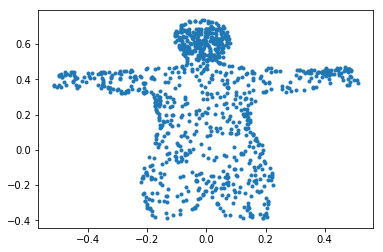

In [15]:
plt.plot(values[1][:,0],values[1][:,1],".")
plt.show()

In [16]:
del Xs,Ys,Zs

In [17]:
del shapes_Xs

In [18]:
ids_int = np.array(list(map(lambda x: re.findall(r'\d+', x),list_ply)),dtype=int).flatten()

In [19]:
ids_int

array([  1,   2,   4,   5,   6,   9,  10,  11,  12,  13,  15,  16,  17,
        18,  19,  20,  21,  24,  25,  26,  28,  30,  33,  34,  35,  36,
        38,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  58,  59,  61,  63,  64,  65,  67,  69,
        70,  71,  73,  74,  75,  78,  79,  80,  81,  82,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  94,  97,  98, 100, 101, 103, 104,
       105, 106, 107, 108, 110, 112, 113, 114, 115, 117, 118, 120, 121,
       122, 123, 124, 125, 127, 128, 130, 135, 136, 137, 138, 139, 141,
       142, 143, 145, 146, 147, 148, 149, 150, 151, 153, 154])

In [20]:
values = values.reshape((values.shape[0],values.shape[1]*values.shape[2]))

# Reducción de dimensionalidad PCA 

In [21]:
pca = decomposition.PCA(n_components=90,svd_solver='full',whiten=True)
pca.fit(values)
print("Con n_components = {} el valor es: {} ".format(90,pca.explained_variance_ratio_.sum()))

Con n_components = 90 el valor es: 0.8617657796702182 


In [22]:
x_out = pca.transform(values)
x_out.shape

(115, 90)

In [23]:
data_reales = pd.read_excel("../../Datos/CampañaVoluntario/23-05-2017-completo.xlsx")

In [24]:
sexo_ids = np.array(data_reales["sexo"][data_reales["id"].isin(ids_int)])

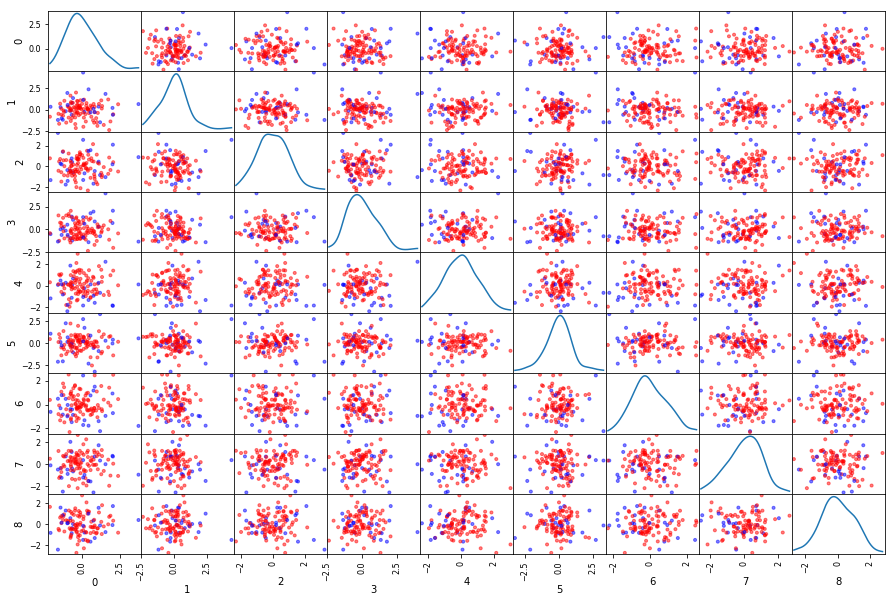

In [25]:
interest_feat = range(10)
data = pd.DataFrame(x_out)
data["labels"]= sexo_ids
color_wheel = {"f": "red", "m": "blue"}
colors = data["labels"].map(lambda x: color_wheel.get(x[0]))
pd.scatter_matrix(data.loc[:,interest_feat[:-1]], figsize=(15,10), diagonal='kde',label=data.loc[:,"labels"],c=colors)
plt.show()

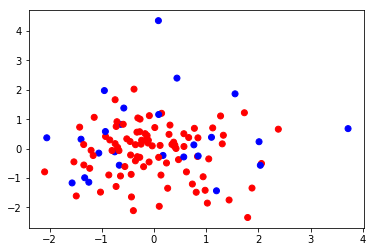

In [26]:
import matplotlib.patches as mpatches
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_out[:,0],x_out[:,1],marker="o",c=colors)
# for label, x, y in zip(np.array(ids_int), x_out[:,0], x_out[:,1]):
#     plt.annotate(
#         label,
#         xy=(x, y), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show()

# Prediciendo

In [27]:
import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [28]:
id_sexo = {"f": 0, "m": 1}
sexo_c = data["labels"].map(lambda x: id_sexo.get(x[0])).tolist()

In [29]:
X = x_out[:]
#X = x_out
y = np.array(sexo_c)

In [30]:
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split( X, y, test_size=0.30, random_state=42)

In [31]:
clf = SVC(kernel='linear')
clf_tree = ExtraTreesClassifier(n_estimators=200,
                           max_features=0.3,
                           #max_depth=4, #20
                           random_state=1)

In [61]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    print("--- SVC Lineal ---")
    #print(clf.score(X_test,y_test))
    scores = cross_val_score(clf, X, y, cv=10)
    print(classification_report(y_test, clf.predict(X_test)))
    clf_tree.fit(X_train, y_train)
    print("--- Tree ---")
    y_pred = clf_tree.predict(X_test)
    scores = cross_val_score(clf_tree, X, y, cv=10)
    print(scores)
    print(classification_report(y_test, clf_tree.predict(X_test)))

--- SVC Lineal ---
             precision    recall  f1-score   support

          0       0.85      0.94      0.89        18
          1       0.67      0.40      0.50         5

avg / total       0.81      0.83      0.81        23

--- Tree ---
[ 0.75  0.75  0.75  0.75  0.67  0.82  0.82  0.82  0.82  0.82]
             precision    recall  f1-score   support

          0       0.78      1.00      0.88        18
          1       0.00      0.00      0.00         5

avg / total       0.61      0.78      0.69        23

--- SVC Lineal ---
             precision    recall  f1-score   support

          0       0.76      0.89      0.82        18
          1       0.00      0.00      0.00         5

avg / total       0.60      0.70      0.64        23



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--- Tree ---
[ 0.75  0.75  0.75  0.75  0.67  0.82  0.82  0.82  0.82  0.82]
             precision    recall  f1-score   support

          0       0.78      1.00      0.88        18
          1       0.00      0.00      0.00         5

avg / total       0.61      0.78      0.69        23

--- SVC Lineal ---
             precision    recall  f1-score   support

          0       0.82      1.00      0.90        18
          1       1.00      0.20      0.33         5

avg / total       0.86      0.83      0.78        23



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--- Tree ---
[ 0.75  0.75  0.75  0.75  0.67  0.82  0.82  0.82  0.82  0.82]
             precision    recall  f1-score   support

          0       0.78      1.00      0.88        18
          1       0.00      0.00      0.00         5

avg / total       0.61      0.78      0.69        23

--- SVC Lineal ---
             precision    recall  f1-score   support

          0       0.80      0.89      0.84        18
          1       0.33      0.20      0.25         5

avg / total       0.70      0.74      0.71        23



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--- Tree ---
[ 0.75  0.75  0.75  0.75  0.67  0.82  0.82  0.82  0.82  0.82]
             precision    recall  f1-score   support

          0       0.78      1.00      0.88        18
          1       0.00      0.00      0.00         5

avg / total       0.61      0.78      0.69        23

--- SVC Lineal ---
             precision    recall  f1-score   support

          0       0.76      0.72      0.74        18
          1       0.17      0.20      0.18         5

avg / total       0.63      0.61      0.62        23



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--- Tree ---
[ 0.75  0.75  0.75  0.75  0.67  0.82  0.82  0.82  0.82  0.82]
             precision    recall  f1-score   support

          0       0.78      1.00      0.88        18
          1       0.00      0.00      0.00         5

avg / total       0.61      0.78      0.69        23



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# sss.get_n_splits(X, y)
# for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     clf = SVC()
#     clf.fit(X_train, y_train)
#     print(clf.score(X_test,y_test))

In [55]:
clf.score(X_test,y_test)

0.60869565217391308

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=10)

In [ ]:
scores.mean()

In [57]:
scores.std()

0.048532173872869629

             precision    recall  f1-score   support

          0       0.76      0.72      0.74        18
          1       0.17      0.20      0.18         5

avg / total       0.63      0.61      0.62        23



In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18  0]
 [ 5  0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


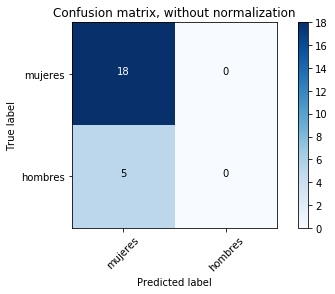

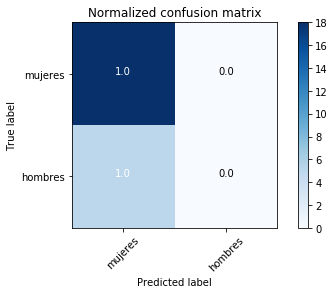

In [54]:
import itertools
from sklearn.metrics import confusion_matrix

y_pred = clf_tree.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["mujeres","hombres"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["mujeres","hombres"], normalize=True,
                      title='Normalized confusion matrix')
plt.show()